# ResNet-18: CIFAR-10 + PyTorch

Trained with:
- linear lr warmup, followed by step-decays.
- __Trainable $\beta$ hyper-parameter__ in Swish activation function.

[SEARCHING FOR ACTIVATION FUNCTIONS](https://arxiv.org/pdf/1710.05941v2.pdf) by Prajit Ramachandran, Barret Zoph and Quoc V. Le; ICLR 2018 paper.

Swish is an activation function: $f(x) = \frac{1}{1 + e^{-\beta \cdot x}}$ where $\beta$ is a learnable parameter. Nearly all implementations do not use the learnable parameter $\beta$, in which case the activation function is $f(x) = \frac{1}{1 + e^{-x}}$ ("Swish-1") - [paperswithcode, swish](https://paperswithcode.com/method/swish).

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os, pickle

from cifar10_dataloader import get_cifar10_data
from ResNet18_trainable_swish_torch import ResNet_Block, ResNet18

In [3]:
print(f"torch version: {torch.__version__}")


# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 2.0.0
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU
Available device is cuda


In [4]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 85

In [5]:
train_loader, val_loader, train_dataset, val_dataset = get_cifar10_data(
    path_to_files = 'C:/Users/arjun/Downloads/data/',
    batch_size = batch_size
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Initialize ResNet-50 CNN architecture-
model = ResNet18(beta = 1.0)

In [7]:
# Move to device-
model = model.to(device)

In [8]:
# Save randomly initialize parameters-
torch.save(model.state_dict(), "ResNet18_random_params.pth")

In [ ]:
# model.load_state_dict(torch.load("ResNet50_best_model.pth"))

In [20]:
'beta' in model.state_dict().keys()

True

In [9]:
def count_trainable_params(model):
    # Count number of layer-wise parameters and total parameters-
    tot_params = 0
    for param in model.parameters():
        # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
        tot_params += param.nelement()

    return tot_params


In [11]:
print(f"ResNet-18 has {count_trainable_params(model = model)} params")

ResNet-18 has 11168833 params


### Learning Rate Scheduler

Training dataset size = 50K, batch-size = 256, number of training steps per epoch = 50K / 256 = 195.3125

After an initial LR warmup of 13 epochs or, 2539.0625 = 2540 training iterations:

- For the next 32 epochs, or, until $45^{th}$ epoch, use lr = 01.

- For the next 25 epochs, or, until $70^{th}$ epoch, use lr = 0.01.

- For remaninig epochs, use lr = 0.001.

In [12]:
boundaries = [8790, 13672]
values = [0.1, 0.01, 0.001]

In [13]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params = model.parameters(), lr = 0.0,
    momentum = 0.9, weight_decay = 5e-4
)

In [14]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [15]:
def decay_function(step, boundaries = [8790, 13672], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


class schedule():
    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
        

In [16]:
# Initial linear LR warmup: 195.3125 x 13 = 2540 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 2540,
    decay_func = decay_function
)

In [17]:
step = 0

In [18]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0
    
    # Set model to evaluation mode-
    model.eval()

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()
 

In [19]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_acc = 0

In [21]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model, train_loader,
        train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model, val_loader,
        val_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f" beta = {model.beta.cpu().detach().numpy():.6f} & LR = {optimizer.param_groups[0]['lr']:.5f}\n"
         )
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr'],
        'beta': model.beta.cpu().detach().numpy()
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet18_swish_best_model.pth")
        

Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 19.16batch/s, val_acc=37.5, val_loss=2.07]



epoch: 1 training loss = 4.2471, training accuracy = 22.26%, val_loss = 2.0669, val_accuracy = 37.53% &  beta = 1.886302 & LR = 0.00768

Saving model with highest val_acc = 37.5300%



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 19.41batch/s, val_acc=47.5, val_loss=1.47]



epoch: 2 training loss = 1.7980, training accuracy = 40.74%, val_loss = 1.4717, val_accuracy = 47.50% &  beta = 2.044027 & LR = 0.01539

Saving model with highest val_acc = 47.5000%



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 18.81batch/s, val_acc=51.8, val_loss=1.38]



epoch: 3 training loss = 1.5028, training accuracy = 47.87%, val_loss = 1.3760, val_accuracy = 51.82% &  beta = 2.081630 & LR = 0.02311

Saving model with highest val_acc = 51.8200%



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 19.55batch/s, val_acc=57.7, val_loss=1.23]



epoch: 4 training loss = 1.3438, training accuracy = 53.10%, val_loss = 1.2282, val_accuracy = 57.66% &  beta = 2.095978 & LR = 0.03083

Saving model with highest val_acc = 57.6600%



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 19.67batch/s, val_acc=62.5, val_loss=1.08]



epoch: 5 training loss = 1.1993, training accuracy = 58.02%, val_loss = 1.0775, val_accuracy = 62.52% &  beta = 2.055020 & LR = 0.03854

Saving model with highest val_acc = 62.5200%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.73batch/s, val_acc=68.1, val_loss=0.936]



epoch: 6 training loss = 1.0850, training accuracy = 62.24%, val_loss = 0.9363, val_accuracy = 68.11% &  beta = 2.147521 & LR = 0.04626

Saving model with highest val_acc = 68.1100%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.71batch/s, val_acc=72, val_loss=0.818]



epoch: 7 training loss = 0.9985, training accuracy = 65.37%, val_loss = 0.8183, val_accuracy = 72.03% &  beta = 2.235134 & LR = 0.05398

Saving model with highest val_acc = 72.0300%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.77batch/s, val_acc=71.2, val_loss=0.834]



epoch: 8 training loss = 0.9420, training accuracy = 67.26%, val_loss = 0.8344, val_accuracy = 71.24% &  beta = 2.299520 & LR = 0.06169



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 19.76batch/s, val_acc=62.1, val_loss=1.21]



epoch: 9 training loss = 0.8796, training accuracy = 69.42%, val_loss = 1.2104, val_accuracy = 62.12% &  beta = 2.523668 & LR = 0.06941



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.71batch/s, val_acc=69.7, val_loss=0.882]



epoch: 10 training loss = 0.8359, training accuracy = 71.25%, val_loss = 0.8819, val_accuracy = 69.69% &  beta = 2.675123 & LR = 0.07713



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.75batch/s, val_acc=75.1, val_loss=0.728]



epoch: 11 training loss = 0.8021, training accuracy = 72.39%, val_loss = 0.7279, val_accuracy = 75.14% &  beta = 2.873386 & LR = 0.08484

Saving model with highest val_acc = 75.1400%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.78batch/s, val_acc=75.1, val_loss=0.741]



epoch: 12 training loss = 0.7767, training accuracy = 73.19%, val_loss = 0.7412, val_accuracy = 75.12% &  beta = 3.043522 & LR = 0.09256



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.74batch/s, val_acc=71.7, val_loss=0.835]



epoch: 13 training loss = 0.7476, training accuracy = 74.16%, val_loss = 0.8354, val_accuracy = 71.69% &  beta = 3.369721 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.71batch/s, val_acc=79.7, val_loss=0.602]



epoch: 14 training loss = 0.7168, training accuracy = 75.20%, val_loss = 0.6021, val_accuracy = 79.70% &  beta = 3.658306 & LR = 0.10000

Saving model with highest val_acc = 79.7000%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.79batch/s, val_acc=78.3, val_loss=0.641]



epoch: 15 training loss = 0.6966, training accuracy = 76.05%, val_loss = 0.6406, val_accuracy = 78.35% &  beta = 4.019728 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.74batch/s, val_acc=74.4, val_loss=0.767]



epoch: 16 training loss = 0.6680, training accuracy = 77.11%, val_loss = 0.7670, val_accuracy = 74.36% &  beta = 4.294059 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.78batch/s, val_acc=82.2, val_loss=0.541]



epoch: 17 training loss = 0.6475, training accuracy = 77.43%, val_loss = 0.5414, val_accuracy = 82.16% &  beta = 4.610133 & LR = 0.10000

Saving model with highest val_acc = 82.1600%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.49batch/s, val_acc=80.3, val_loss=0.565]



epoch: 18 training loss = 0.6296, training accuracy = 78.38%, val_loss = 0.5649, val_accuracy = 80.27% &  beta = 4.911165 & LR = 0.10000



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.74batch/s, val_acc=81, val_loss=0.566]



epoch: 19 training loss = 0.6183, training accuracy = 78.76%, val_loss = 0.5663, val_accuracy = 81.02% &  beta = 5.193012 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.80batch/s, val_acc=72.2, val_loss=0.832]



epoch: 20 training loss = 0.6061, training accuracy = 79.24%, val_loss = 0.8319, val_accuracy = 72.21% &  beta = 5.481262 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.78batch/s, val_acc=80.1, val_loss=0.594]



epoch: 21 training loss = 0.6007, training accuracy = 79.44%, val_loss = 0.5944, val_accuracy = 80.08% &  beta = 5.733926 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.77batch/s, val_acc=83.4, val_loss=0.511]



epoch: 22 training loss = 0.5879, training accuracy = 79.72%, val_loss = 0.5110, val_accuracy = 83.39% &  beta = 5.951094 & LR = 0.10000

Saving model with highest val_acc = 83.3900%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.72batch/s, val_acc=83.4, val_loss=0.493]



epoch: 23 training loss = 0.5832, training accuracy = 80.10%, val_loss = 0.4927, val_accuracy = 83.37% &  beta = 6.076081 & LR = 0.10000



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.72batch/s, val_acc=82, val_loss=0.548]



epoch: 24 training loss = 0.5715, training accuracy = 80.39%, val_loss = 0.5475, val_accuracy = 81.98% &  beta = 6.217688 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.57batch/s, val_acc=73.5, val_loss=0.859]



epoch: 25 training loss = 0.5653, training accuracy = 80.52%, val_loss = 0.8594, val_accuracy = 73.48% &  beta = 6.308719 & LR = 0.10000



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 19.58batch/s, val_acc=84.2, val_loss=0.47]



epoch: 26 training loss = 0.5534, training accuracy = 81.12%, val_loss = 0.4703, val_accuracy = 84.25% &  beta = 6.451999 & LR = 0.10000

Saving model with highest val_acc = 84.2500%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.63batch/s, val_acc=81.1, val_loss=0.579]



epoch: 27 training loss = 0.5422, training accuracy = 81.40%, val_loss = 0.5786, val_accuracy = 81.13% &  beta = 6.526549 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.60batch/s, val_acc=82.7, val_loss=0.512]



epoch: 28 training loss = 0.5467, training accuracy = 81.31%, val_loss = 0.5115, val_accuracy = 82.73% &  beta = 6.561112 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.64batch/s, val_acc=82.3, val_loss=0.527]



epoch: 29 training loss = 0.5406, training accuracy = 81.64%, val_loss = 0.5274, val_accuracy = 82.32% &  beta = 6.590678 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.70batch/s, val_acc=82.8, val_loss=0.527]



epoch: 30 training loss = 0.5360, training accuracy = 81.49%, val_loss = 0.5270, val_accuracy = 82.85% &  beta = 6.627245 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.64batch/s, val_acc=81.6, val_loss=0.568]



epoch: 31 training loss = 0.5307, training accuracy = 81.70%, val_loss = 0.5679, val_accuracy = 81.62% &  beta = 6.661466 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.66batch/s, val_acc=81.9, val_loss=0.574]



epoch: 32 training loss = 0.5281, training accuracy = 81.88%, val_loss = 0.5737, val_accuracy = 81.88% &  beta = 6.647497 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.64batch/s, val_acc=82.2, val_loss=0.543]



epoch: 33 training loss = 0.5197, training accuracy = 82.26%, val_loss = 0.5431, val_accuracy = 82.23% &  beta = 6.642533 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.65batch/s, val_acc=77.3, val_loss=0.708]



epoch: 34 training loss = 0.5185, training accuracy = 82.38%, val_loss = 0.7081, val_accuracy = 77.33% &  beta = 6.626249 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.70batch/s, val_acc=82.2, val_loss=0.537]



epoch: 35 training loss = 0.5190, training accuracy = 82.20%, val_loss = 0.5372, val_accuracy = 82.15% &  beta = 6.683588 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.65batch/s, val_acc=85.8, val_loss=0.439]



epoch: 36 training loss = 0.5062, training accuracy = 82.90%, val_loss = 0.4387, val_accuracy = 85.78% &  beta = 6.662245 & LR = 0.10000

Saving model with highest val_acc = 85.7800%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.64batch/s, val_acc=83.4, val_loss=0.507]



epoch: 37 training loss = 0.5030, training accuracy = 82.94%, val_loss = 0.5069, val_accuracy = 83.36% &  beta = 6.667841 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.82batch/s, val_acc=85.5, val_loss=0.439]



epoch: 38 training loss = 0.4992, training accuracy = 82.89%, val_loss = 0.4388, val_accuracy = 85.49% &  beta = 6.660444 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 13.35batch/s, val_acc=82.9, val_loss=0.515]



epoch: 39 training loss = 0.4964, training accuracy = 83.09%, val_loss = 0.5148, val_accuracy = 82.88% &  beta = 6.648847 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.65batch/s, val_acc=85.3, val_loss=0.437]



epoch: 40 training loss = 0.4951, training accuracy = 83.11%, val_loss = 0.4369, val_accuracy = 85.31% &  beta = 6.615694 & LR = 0.10000



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.65batch/s, val_acc=83.8, val_loss=0.5]



epoch: 41 training loss = 0.4897, training accuracy = 83.23%, val_loss = 0.4999, val_accuracy = 83.84% &  beta = 6.564793 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.65batch/s, val_acc=85.1, val_loss=0.449]



epoch: 42 training loss = 0.4903, training accuracy = 83.17%, val_loss = 0.4494, val_accuracy = 85.12% &  beta = 6.569628 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.68batch/s, val_acc=81.7, val_loss=0.549]



epoch: 43 training loss = 0.4813, training accuracy = 83.41%, val_loss = 0.5486, val_accuracy = 81.68% &  beta = 6.586953 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.66batch/s, val_acc=82.2, val_loss=0.527]



epoch: 44 training loss = 0.4847, training accuracy = 83.41%, val_loss = 0.5274, val_accuracy = 82.18% &  beta = 6.581092 & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.44batch/s, val_acc=89.3, val_loss=0.314]



epoch: 45 training loss = 0.4670, training accuracy = 83.96%, val_loss = 0.3142, val_accuracy = 89.27% &  beta = 6.555890 & LR = 0.01000

Saving model with highest val_acc = 89.2700%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.65batch/s, val_acc=91.1, val_loss=0.265]



epoch: 46 training loss = 0.3217, training accuracy = 89.11%, val_loss = 0.2646, val_accuracy = 91.10% &  beta = 6.553314 & LR = 0.01000

Saving model with highest val_acc = 91.1000%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.64batch/s, val_acc=91.5, val_loss=0.251]



epoch: 47 training loss = 0.2777, training accuracy = 90.72%, val_loss = 0.2506, val_accuracy = 91.48% &  beta = 6.543442 & LR = 0.01000

Saving model with highest val_acc = 91.4800%



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 19.60batch/s, val_acc=91.5, val_loss=0.25]



epoch: 48 training loss = 0.2599, training accuracy = 91.21%, val_loss = 0.2499, val_accuracy = 91.48% &  beta = 6.531926 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.59batch/s, val_acc=91.9, val_loss=0.241]



epoch: 49 training loss = 0.2416, training accuracy = 91.77%, val_loss = 0.2406, val_accuracy = 91.89% &  beta = 6.521212 & LR = 0.01000

Saving model with highest val_acc = 91.8900%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.59batch/s, val_acc=91.7, val_loss=0.241]



epoch: 50 training loss = 0.2301, training accuracy = 92.25%, val_loss = 0.2408, val_accuracy = 91.74% &  beta = 6.521156 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.60batch/s, val_acc=92.1, val_loss=0.237]



epoch: 51 training loss = 0.2230, training accuracy = 92.34%, val_loss = 0.2372, val_accuracy = 92.07% &  beta = 6.512432 & LR = 0.01000

Saving model with highest val_acc = 92.0700%



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 19.61batch/s, val_acc=91.9, val_loss=0.24]



epoch: 52 training loss = 0.2113, training accuracy = 93.02%, val_loss = 0.2396, val_accuracy = 91.93% &  beta = 6.505198 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.67batch/s, val_acc=92.1, val_loss=0.243]



epoch: 53 training loss = 0.2109, training accuracy = 92.85%, val_loss = 0.2431, val_accuracy = 92.07% &  beta = 6.501472 & LR = 0.01000



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 19.66batch/s, val_acc=92.2, val_loss=0.24]



epoch: 54 training loss = 0.1967, training accuracy = 93.42%, val_loss = 0.2404, val_accuracy = 92.15% &  beta = 6.496717 & LR = 0.01000

Saving model with highest val_acc = 92.1500%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.64batch/s, val_acc=92.2, val_loss=0.239]



epoch: 55 training loss = 0.1943, training accuracy = 93.51%, val_loss = 0.2390, val_accuracy = 92.17% &  beta = 6.494266 & LR = 0.01000

Saving model with highest val_acc = 92.1700%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.71batch/s, val_acc=92.2, val_loss=0.241]



epoch: 56 training loss = 0.1913, training accuracy = 93.71%, val_loss = 0.2409, val_accuracy = 92.24% &  beta = 6.489770 & LR = 0.01000

Saving model with highest val_acc = 92.2400%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.64batch/s, val_acc=92, val_loss=0.254]



epoch: 57 training loss = 0.1797, training accuracy = 94.10%, val_loss = 0.2536, val_accuracy = 92.03% &  beta = 6.491140 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.61batch/s, val_acc=92.5, val_loss=0.237]



epoch: 58 training loss = 0.1746, training accuracy = 94.18%, val_loss = 0.2369, val_accuracy = 92.45% &  beta = 6.496712 & LR = 0.01000

Saving model with highest val_acc = 92.4500%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.66batch/s, val_acc=91.9, val_loss=0.248]



epoch: 59 training loss = 0.1728, training accuracy = 94.24%, val_loss = 0.2481, val_accuracy = 91.86% &  beta = 6.505071 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.62batch/s, val_acc=92.1, val_loss=0.248]



epoch: 60 training loss = 0.1704, training accuracy = 94.20%, val_loss = 0.2484, val_accuracy = 92.12% &  beta = 6.517155 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.51batch/s, val_acc=92.2, val_loss=0.241]



epoch: 61 training loss = 0.1674, training accuracy = 94.48%, val_loss = 0.2409, val_accuracy = 92.18% &  beta = 6.516994 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.62batch/s, val_acc=92.2, val_loss=0.245]



epoch: 62 training loss = 0.1641, training accuracy = 94.60%, val_loss = 0.2454, val_accuracy = 92.21% &  beta = 6.520722 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.57batch/s, val_acc=92.1, val_loss=0.252]



epoch: 63 training loss = 0.1551, training accuracy = 94.84%, val_loss = 0.2520, val_accuracy = 92.10% &  beta = 6.528920 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.61batch/s, val_acc=92.3, val_loss=0.246]



epoch: 64 training loss = 0.1542, training accuracy = 94.98%, val_loss = 0.2459, val_accuracy = 92.27% &  beta = 6.540968 & LR = 0.01000



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.65batch/s, val_acc=92, val_loss=0.254]



epoch: 65 training loss = 0.1566, training accuracy = 94.87%, val_loss = 0.2536, val_accuracy = 92.04% &  beta = 6.548135 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.57batch/s, val_acc=92.3, val_loss=0.258]



epoch: 66 training loss = 0.1485, training accuracy = 95.27%, val_loss = 0.2578, val_accuracy = 92.26% &  beta = 6.559021 & LR = 0.01000



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 19.64batch/s, val_acc=91.5, val_loss=0.27]



epoch: 67 training loss = 0.1455, training accuracy = 95.20%, val_loss = 0.2701, val_accuracy = 91.52% &  beta = 6.566317 & LR = 0.01000



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.60batch/s, val_acc=92, val_loss=0.258]



epoch: 68 training loss = 0.1437, training accuracy = 95.38%, val_loss = 0.2575, val_accuracy = 91.95% &  beta = 6.574825 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.60batch/s, val_acc=92.2, val_loss=0.249]



epoch: 69 training loss = 0.1389, training accuracy = 95.42%, val_loss = 0.2493, val_accuracy = 92.22% &  beta = 6.583127 & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.60batch/s, val_acc=92.5, val_loss=0.241]



epoch: 70 training loss = 0.1396, training accuracy = 95.44%, val_loss = 0.2413, val_accuracy = 92.48% &  beta = 6.593835 & LR = 0.00100

Saving model with highest val_acc = 92.4800%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.61batch/s, val_acc=93, val_loss=0.233]



epoch: 71 training loss = 0.1205, training accuracy = 96.08%, val_loss = 0.2326, val_accuracy = 93.05% &  beta = 6.594110 & LR = 0.00100

Saving model with highest val_acc = 93.0500%



Validation: : 100%|██████████████████████████████████████| 40/40 [00:02<00:00, 19.54batch/s, val_acc=93, val_loss=0.23]



epoch: 72 training loss = 0.1120, training accuracy = 96.44%, val_loss = 0.2301, val_accuracy = 92.98% &  beta = 6.595648 & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.63batch/s, val_acc=93.1, val_loss=0.232]



epoch: 73 training loss = 0.1109, training accuracy = 96.61%, val_loss = 0.2324, val_accuracy = 93.07% &  beta = 6.595726 & LR = 0.00100

Saving model with highest val_acc = 93.0700%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.56batch/s, val_acc=93, val_loss=0.231]



epoch: 74 training loss = 0.1054, training accuracy = 96.79%, val_loss = 0.2308, val_accuracy = 93.04% &  beta = 6.594266 & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.61batch/s, val_acc=93, val_loss=0.233]



epoch: 75 training loss = 0.1041, training accuracy = 96.74%, val_loss = 0.2328, val_accuracy = 93.05% &  beta = 6.592986 & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.66batch/s, val_acc=93, val_loss=0.231]



epoch: 76 training loss = 0.1027, training accuracy = 96.78%, val_loss = 0.2309, val_accuracy = 93.04% &  beta = 6.592631 & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.60batch/s, val_acc=93, val_loss=0.231]



epoch: 77 training loss = 0.1023, training accuracy = 96.90%, val_loss = 0.2314, val_accuracy = 93.03% &  beta = 6.591558 & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.68batch/s, val_acc=93, val_loss=0.233]



epoch: 78 training loss = 0.0988, training accuracy = 96.92%, val_loss = 0.2329, val_accuracy = 92.96% &  beta = 6.590920 & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.63batch/s, val_acc=93, val_loss=0.232]



epoch: 79 training loss = 0.1003, training accuracy = 96.93%, val_loss = 0.2322, val_accuracy = 93.04% &  beta = 6.589186 & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.69batch/s, val_acc=93, val_loss=0.234]



epoch: 80 training loss = 0.0983, training accuracy = 96.94%, val_loss = 0.2341, val_accuracy = 93.00% &  beta = 6.588081 & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.62batch/s, val_acc=93.2, val_loss=0.231]



epoch: 81 training loss = 0.0947, training accuracy = 97.10%, val_loss = 0.2306, val_accuracy = 93.19% &  beta = 6.587454 & LR = 0.00100

Saving model with highest val_acc = 93.1900%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.65batch/s, val_acc=93.1, val_loss=0.231]



epoch: 82 training loss = 0.0944, training accuracy = 97.13%, val_loss = 0.2311, val_accuracy = 93.08% &  beta = 6.586453 & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.62batch/s, val_acc=93, val_loss=0.232]



epoch: 83 training loss = 0.0927, training accuracy = 97.10%, val_loss = 0.2318, val_accuracy = 93.01% &  beta = 6.585247 & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.45batch/s, val_acc=93.2, val_loss=0.234]



epoch: 84 training loss = 0.0924, training accuracy = 97.11%, val_loss = 0.2336, val_accuracy = 93.18% &  beta = 6.584311 & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.40batch/s, val_acc=93, val_loss=0.235]


epoch: 85 training loss = 0.0931, training accuracy = 97.19%, val_loss = 0.2350, val_accuracy = 92.99% &  beta = 6.581717 & LR = 0.00100



In [22]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet18_trainable_Swish_training_history.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

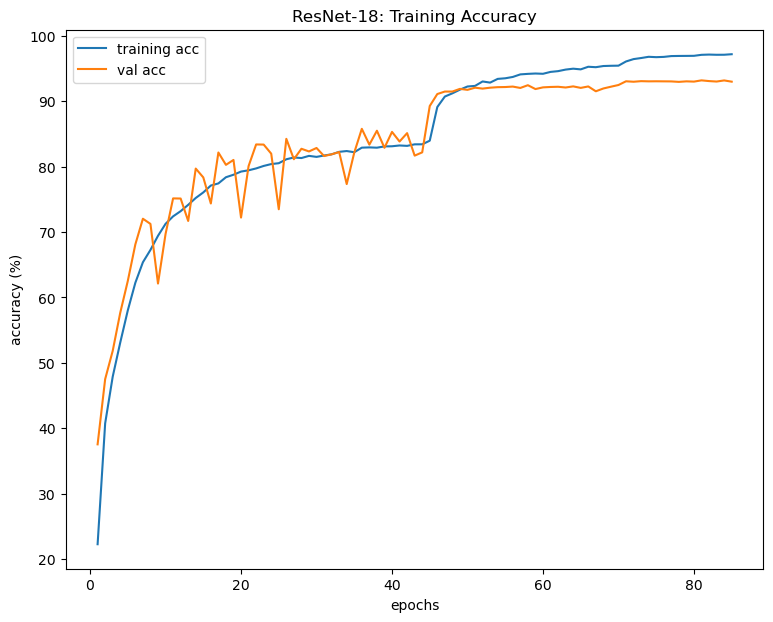

In [23]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-18: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

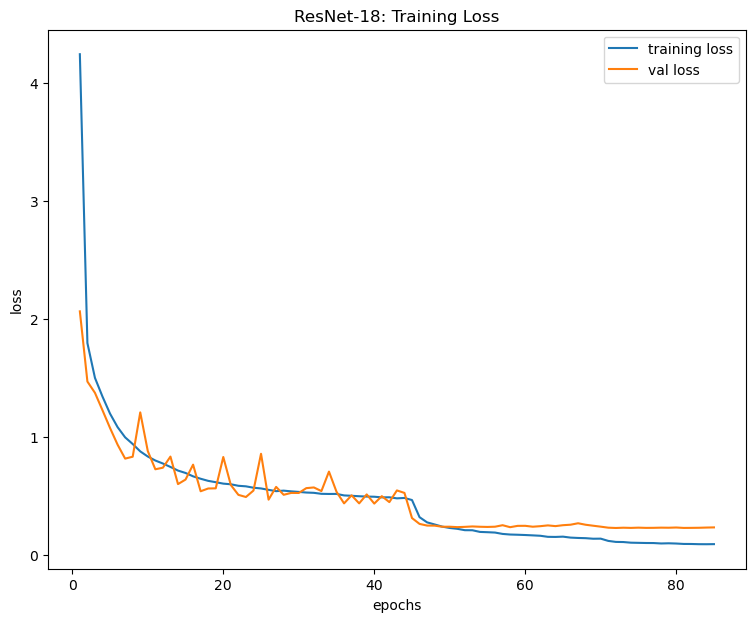

In [24]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-18: Training Loss")
plt.show()

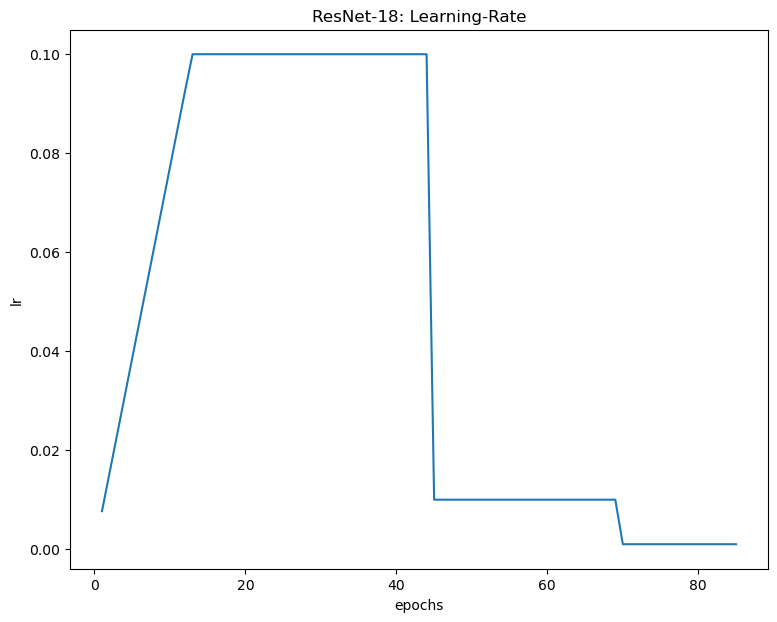

In [25]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: Learning-Rate")
plt.show()

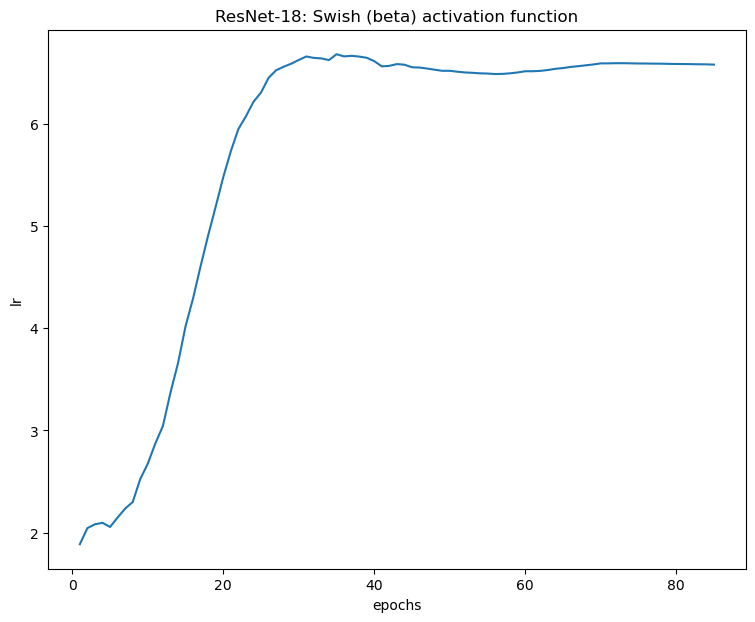

In [26]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['beta'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: Swish (beta) activation function")
plt.show()

In [27]:
del model

In [ ]:
# Initialize and load 'best' trained parameters from above-
best_model = ResNet18(beta = 1.0)
best_model.load_state_dict(torch.load("ResNet18_swish_best_model.pth"))

# Move to GPU device-
best_model.to(device)

In [29]:
# Get validation metrics of 'best' trained model-
val_loss, val_acc = test_model_progress(
    model = best_model, test_loader = val_loader,
    test_dataset = val_dataset
)

Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 16.53batch/s, val_acc=93.2, val_loss=0.231]


In [30]:
print("ResNet-18 'best' trained validation metrics: ",
      f"loss = {val_loss:.4f} & acc = {val_acc:.2f}%"
     )

ResNet-18 'best' trained validation metrics:  loss = 0.2306 & acc = 93.19%


In [32]:
# max([train_history[k]['val_acc'] for k in train_history.keys()])
max_val_acc = 0
max_epoch = 0

for e in training_history_lr_scheduler.keys():
    if training_history_lr_scheduler[e]['val_acc'] > max_val_acc:
        max_val_acc = training_history_lr_scheduler[e]['val_acc']
        max_epoch = e

In [34]:
print(f"highest val acc = {training_history_lr_scheduler[max_epoch]['val_acc']:.2f}%",
      f" is obtained for beta = {training_history_lr_scheduler[max_epoch]['beta']:.4f}"
)

highest val acc = 93.19%  is obtained for beta = 6.5875


In [35]:
def compute_swish_fn(x, b = 1.0):
    return x * (1 / (1 + np.exp(-b * x)))

In [42]:
x = np.arange(-10, 11, 0.01)

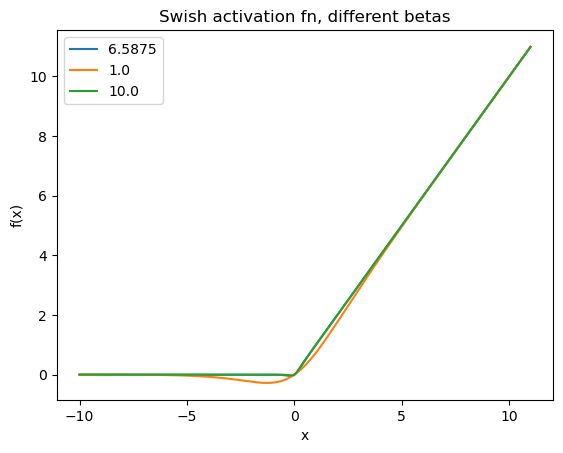

In [48]:
plt.plot(x, compute_swish_fn(x = x, b = 6.5875), label = '6.5875')
plt.plot(x, compute_swish_fn(x = x, b = 1.0), label = '1.0')
plt.plot(x, compute_swish_fn(x = x, b = 10.0), label = '10.0')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Swish activation fn, different betas")
plt.legend(loc = 'best')
plt.show()

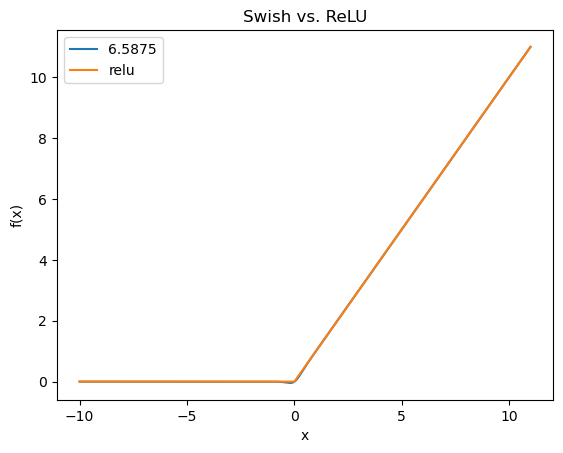

In [49]:
plt.plot(x, compute_swish_fn(x = x, b = 6.5875), label = '6.5875')
plt.plot(x, np.where(x <= 0, 0.0, x), label = 'relu')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Swish vs. ReLU")
plt.legend(loc = 'best')
plt.show()

In [51]:
x = np.arange(-2, 2, 0.01)

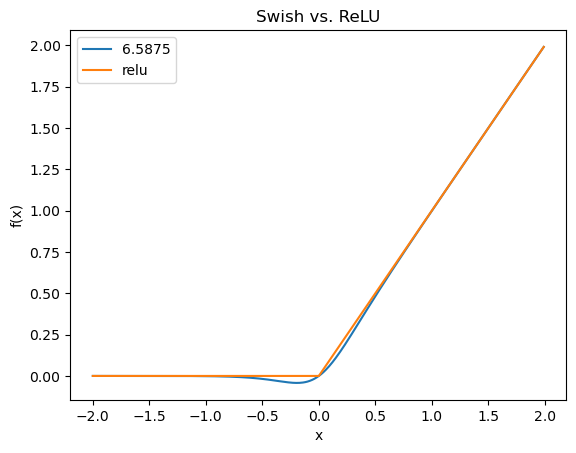

In [52]:
plt.plot(x, compute_swish_fn(x = x, b = 6.5875), label = '6.5875')
plt.plot(x, np.where(x <= 0, 0.0, x), label = 'relu')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Swish vs. ReLU")
plt.legend(loc = 'best')
plt.show()

In [53]:
x = np.arange(-1.2, 1.2, 0.01)

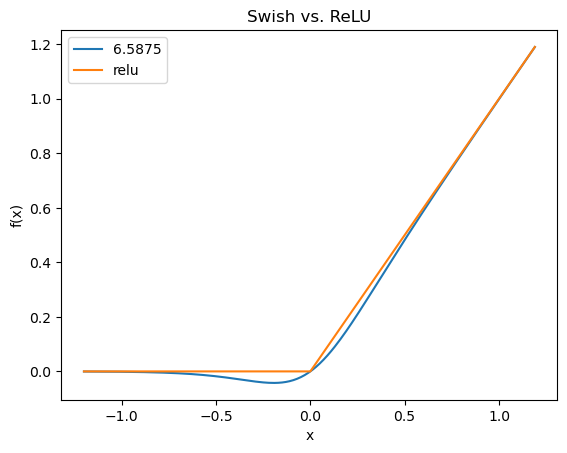

In [54]:
plt.plot(x, compute_swish_fn(x = x, b = 6.5875), label = '6.5875')
plt.plot(x, np.where(x <= 0, 0.0, x), label = 'relu')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Swish vs. ReLU")
plt.legend(loc = 'best')
plt.show()

#### Observation

Except for a small interval $x \in [-1.0, + 1.0]$ (approximately), both, trainable swish and relu (seem to) behave in a similar manner.